Text(0.5, 1.0, '2D Mean Spectrum')

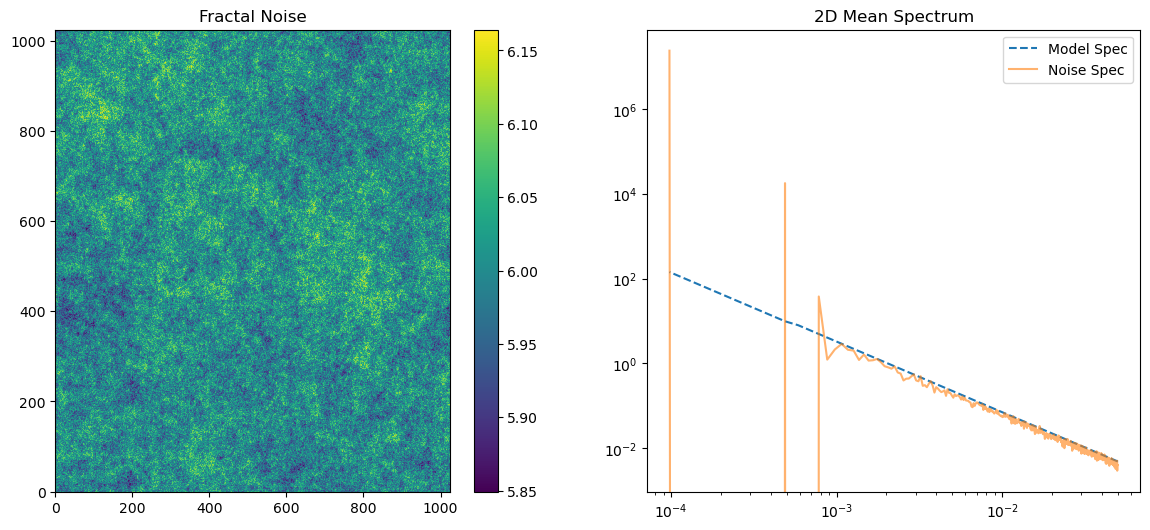

In [66]:
import matplotlib.pyplot as plt
import numpy as num
from scipy import interpolate
%matplotlib inline

shift = num.fft.fftshift
fig, ax = plt.subplots(1, 2, figsize=(14,6))

'''
Create fractal noise
'''
nN, nE = 1024, 1024
dE, dN = 10., 10.  # Arbitrary values for sampling in dx and dy
amplitude = 12.

rfield = num.random.rand(nN, nE)
spec = num.fft.fft2(rfield)

regime = num.array([.01, .1, 1.])
beta = num.array([5./3, 5/3, 5/3])
#beta += 1.  # Betas are defined for 1D PowerSpec, increasing dimension

kE = num.fft.fftfreq(nE, dE)
kN = num.fft.fftfreq(nN, dN)

k = kN if kN.size < kE.size else kE
k = k[k > 0]
k_rad = num.sqrt(kN[:, num.newaxis]**2 + kE[num.newaxis, :]**2)

k0 = 0
k1 = regime[0] * k.max()
k2 = regime[1] * k.max()

r0 = num.logical_and(k_rad > k0, k_rad < k1)
r1 = num.logical_and(k_rad >= k1, k_rad < k2)
r2 = k_rad >= k2

amp = num.empty_like(k_rad)
amp[r0] = k_rad[r0] ** -beta[0]
amp[r0] /= amp[r0].max()

amp[r1] = k_rad[r1] ** -beta[1]
amp[r1] /= amp[r1].max()/amp[r0].min()

amp[r2] = k_rad[r2] ** -beta[2]
amp[r2] /= amp[r2].max()/amp[r1].min()

amp[k_rad == 0.] = amp.max()

amp *= amplitude**2
spec *= num.sqrt(amp)  # We come from powerspec!
noise = num.abs(num.fft.ifft2(spec))

ampN_slice = shift(amp)[:int(amp.shape[0]/2), int(amp.shape[1]/2)]
kN_slice = shift(k_rad)[:int(amp.shape[0]/2), int(amp.shape[1]/2)]

ampE_slice = shift(amp)[int(amp.shape[0]/2), :int(amp.shape[1]/2)]
kE_slice = shift(k_rad)[int(amp.shape[0]/2), :int(amp.shape[1]/2)]

pmesh = ax[0].pcolormesh(noise)
plt.colorbar(pmesh, ax= ax[0])
ax[0].set_title('Fractal Noise')


'''
Model spec for 1D (used for comparison)
'''
k = num.linspace(max(kE[kE > 0.].min(), kN[kN > 0.].min()),
                 max(kE.max(), kN.max()), 512)
k1d = k

r0 = num.logical_and(k1d >= k0, k1d < k1)
r1 = num.logical_and(k1d >= k1, k1d < k2)
r2 = k1d >= k2

beta1d = num.array([5./3, 8./3, 2./3])
amp1d = num.zeros_like(k1d)

amp1d[r0] = k[r0] ** -(beta1d[0])
amp1d[r0] /= amp1d[r0].max()

amp1d[r1] = k[r1] ** -(beta1d[1])
amp1d[r1] /= amp1d[r1].max()/amp1d[r0].min()

s2 = k ** -beta[1]
amp1d[r2] = k[r2] ** -(beta1d[2])
amp1d[r2] /= amp1d[r2].max()/amp1d[r1].min()

amp1d *= amplitude**2  # We are in the powerspec


'''
Noise analysis from random 2D spectrum
'''
spec = shift(num.fft.fft2(noise))
pspec = num.abs(spec)**2
pspec[k_rad == 0.] = 0.

kE = shift(num.fft.fftfreq(spec.shape[1], dE))
kN = shift(num.fft.fftfreq(spec.shape[0], dN))
k_rad = num.sqrt(kN[:, num.newaxis]**2 + kE[num.newaxis, :]**2)

kE = shift(num.fft.fftfreq(spec.shape[1], dE))
kN = shift(num.fft.fftfreq(spec.shape[0], dN))

power_interp = interpolate.RectBivariateSpline(kN, kE, pspec)


def power2DMean(k, N=256):
    """ Mean 2D Power works! """
    theta = num.linspace(-num.pi, num.pi, N, False)
    power = num.empty_like(k)
    for i in range(k.size):
        kE = num.sin(theta) * k[i]
        kN = num.cos(theta) * k[i]
        power[i] = num.median(power_interp.ev(kN, kE) * 4 * num.pi)
        # Median is more stable than the mean here
    return power / pspec.size


def power1D(k, N=256):
    """ Here we need to normalize the power over the radius
    But scaling does not work """
    theta = num.linspace(-num.pi, num.pi, N, False)
    power = num.empty_like(k)
    for i in range(k.size):
        kE = num.sin(theta) * k[i]
        kN = num.cos(theta) * k[i]
        power[i] = num.median(power_interp.ev(kN, kE) * k[i])
    return power


ax[1].loglog(kE_slice, ampE_slice, ls='--', label='Model Spec')
ax[1].loglog(k, power2DMean(k), alpha=.6, label='Noise Spec')
ax[1].legend()
ax[1].set_title('2D Mean Spectrum')
# dist = 10**(num.log10(ampE_slice) - num.log10(power1D(kE_slice)))

# ax[2].loglog(k1d, amp1d, ls='--', label='Model Spec')
# ax[2].loglog(k1d, power1D(k1d), alpha=.6, label='Noise Spec')
# ax[2].legend()
# ax[2].set_title('1D Averaged Spectrum')
#plt.show()

# dist = 10**(num.log10(amp1d) - num.log10(power1D(k1d)))

In [67]:
import scipy.signal
import numpy as np
filter_kernel = np.ones((100,100))
filter_kernel /= np.sum(filter_kernel)

avg10by10_noise = scipy.signal.convolve2d(noise, filter_kernel,
                              mode='same', boundary='wrap')#, fillvalue=0)

avg10by10_noise2 = scipy.signal.convolve2d(noise**2, filter_kernel,
                              mode='same', boundary='wrap')#, fillvalue=0)

std = np.sqrt(avg10by10_noise2 - avg10by10_noise*avg10by10_noise)


In [68]:
data = np.stack([noise.flatten(), avg10by10_noise.flatten() , noise.flatten() - avg10by10_noise.flatten(), std.flatten()])

In [69]:
sort_indices = np.argsort(data[1])
sortedV = data[:, sort_indices]

In [70]:
sortedV.shape

(4, 1048576)

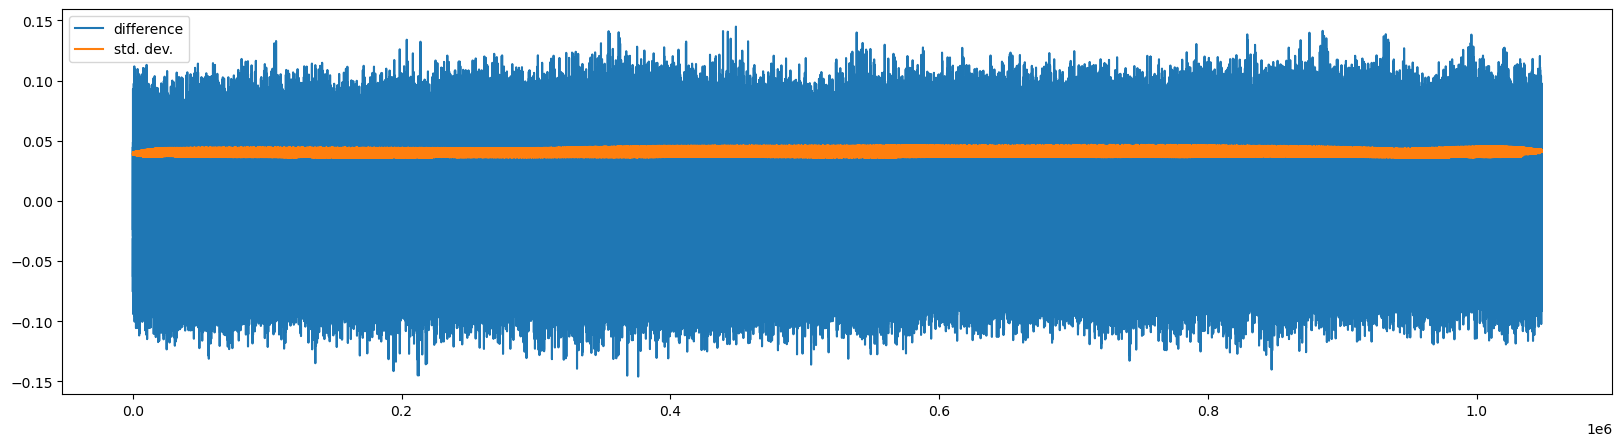

In [71]:
plt.figure(figsize=(20,5))
# plt.plot(sortedV[0,:])
# plt.plot(sortedV[1,:])
plt.plot(sortedV[2,:], label='difference')
plt.plot(sortedV[3,:], label='std. dev.')
plt.legend()

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as num
# from scipy import interpolate
# %matplotlib inline

# shift = num.fft.fftshift
fig, ax = plt.subplots(1, 2, figsize=(14,6))

'''
Create fractal noise
'''
nN, nE = 1024, 1024
dE, dN = 10., 10.  # Arbitrary values for sampling in dx and dy
amplitude = 5.

rfield = num.random.rand(nN, nE)
spec = num.fft.fft2(rfield)

regime = num.array([.01, .1, 1.])
beta = num.array([5./3, 5, 3])
#beta += 1.  # Betas are defined for 1D PowerSpec, increasing dimension

kE = num.fft.fftfreq(nE, dE)
kN = num.fft.fftfreq(nN, dN)

k = kN if kN.size < kE.size else kE
k = k[k > 0]
k_rad = num.sqrt(kN[:, num.newaxis]**2 + kE[num.newaxis, :]**2)

k0 = 0
k1 = regime[0] * k.max()
k2 = regime[1] * k.max()

r0 = num.logical_and(k_rad > k0, k_rad < k1)
r1 = num.logical_and(k_rad >= k1, k_rad < k2)
r2 = k_rad >= k2

amp = num.empty_like(k_rad)
amp[r0] = k_rad[r0] ** -beta[0]
amp[r0] /= amp[r0].max()

amp[r1] = k_rad[r1] ** -beta[1]
amp[r1] /= amp[r1].max()/amp[r0].min()

amp[r2] = k_rad[r2] ** -beta[2]
amp[r2] /= amp[r2].max()/amp[r1].min()

amp[k_rad == 0.] = amp.max()

amp *= amplitude**2
spec *= num.sqrt(amp)  # We come from powerspec!
noise = num.abs(num.fft.ifft2(spec))

ampN_slice = shift(amp)[:int(amp.shape[0]/2), int(amp.shape[1]/2)]
kN_slice = shift(k_rad)[:int(amp.shape[0]/2), int(amp.shape[1]/2)]

ampE_slice = shift(amp)[int(amp.shape[0]/2), :int(amp.shape[1]/2)]
kE_slice = shift(k_rad)[int(amp.shape[0]/2), :int(amp.shape[1]/2)]

pmesh = ax[0].pcolormesh(noise)
plt.colorbar(pmesh, ax= ax[0])
ax[0].set_title('Fractal Noise')


'''
Model spec for 1D (used for comparison)
'''
k = num.linspace(max(kE[kE > 0.].min(), kN[kN > 0.].min()),
                 max(kE.max(), kN.max()), 512)
k1d = k

r0 = num.logical_and(k1d >= k0, k1d < k1)
r1 = num.logical_and(k1d >= k1, k1d < k2)
r2 = k1d >= k2

beta1d = num.array([5./3, 8./3, 2./3])
amp1d = num.zeros_like(k1d)

amp1d[r0] = k[r0] ** -(beta1d[0])
amp1d[r0] /= amp1d[r0].max()

amp1d[r1] = k[r1] ** -(beta1d[1])
amp1d[r1] /= amp1d[r1].max()/amp1d[r0].min()

s2 = k ** -beta[1]
amp1d[r2] = k[r2] ** -(beta1d[2])
amp1d[r2] /= amp1d[r2].max()/amp1d[r1].min()

amp1d *= amplitude**2  # We are in the powerspec


'''
Noise analysis from random 2D spectrum
'''
spec = shift(num.fft.fft2(noise))
pspec = num.abs(spec)**2
pspec[k_rad == 0.] = 0.

kE = shift(num.fft.fftfreq(spec.shape[1], dE))
kN = shift(num.fft.fftfreq(spec.shape[0], dN))
k_rad = num.sqrt(kN[:, num.newaxis]**2 + kE[num.newaxis, :]**2)

kE = shift(num.fft.fftfreq(spec.shape[1], dE))
kN = shift(num.fft.fftfreq(spec.shape[0], dN))

power_interp = interpolate.RectBivariateSpline(kN, kE, pspec)


def power2DMean(k, N=256):
    """ Mean 2D Power works! """
    theta = num.linspace(-num.pi, num.pi, N, False)
    power = num.empty_like(k)
    for i in range(k.size):
        kE = num.sin(theta) * k[i]
        kN = num.cos(theta) * k[i]
        power[i] = num.median(power_interp.ev(kN, kE) * 4 * num.pi)
        # Median is more stable than the mean here
    return power / pspec.size


def power1D(k, N=256):
    """ Here we need to normalize the power over the radius
    But scaling does not work """
    theta = num.linspace(-num.pi, num.pi, N, False)
    power = num.empty_like(k)
    for i in range(k.size):
        kE = num.sin(theta) * k[i]
        kN = num.cos(theta) * k[i]
        power[i] = num.median(power_interp.ev(kN, kE) * k[i])
    return power


ax[1].loglog(kE_slice, ampE_slice, ls='--', label='Model Spec')
ax[1].loglog(k, power2DMean(k), alpha=.6, label='Noise Spec')
ax[1].legend()
ax[1].set_title('2D Mean Spectrum')
# dist = 10**(num.log10(ampE_slice) - num.log10(power1D(kE_slice)))

# ax[2].loglog(k1d, amp1d, ls='--', label='Model Spec')
# ax[2].loglog(k1d, power1D(k1d), alpha=.6, label='Noise Spec')
# ax[2].legend()
# ax[2].set_title('1D Averaged Spectrum')
#plt.show()

# dist = 10**(num.log10(amp1d) - num.log10(power1D(k1d)))